# Knowledge distillation
Suppose that we have a large network (*teacher network*) or an ensemble of networks which has a good accuracy but doesn't fit into memory/runtime requirements. Instead of training a smaller network (*student network*) directly on the original dataset, we can train this network to predict outputs of teacher networks. It turns out that the perfomance could be even better! This approach doesn't help with training speed, but can be quite beneficial when we'd like to reduce the model size for low-memory devices.

* https://www.ttic.edu/dl/dark14.pdf
* [Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531)
* https://medium.com/neural-machines/knowledge-distillation-dc241d7c2322

Even the completely different ([article](https://arxiv.org/abs/1711.10433)) architecture can be used in a student model, e.g. you can approximate an autoregressive model (WaveNet) by a non-autoregressive one.

Подготавливаем данные

In [ ]:
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py' -O tiny_img.py
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py' -O tiny_img_dataset.py

--2023-10-11 09:36:20--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 813 [text/plain]
Saving to: ‘tiny_img.py’

tiny_img.py         100%[===================>]     813  --.-KB/s    in 0s      

2023-10-11 09:36:21 (58.7 MB/s) - ‘tiny_img.py’ saved [813/813]

--2023-10-11 09:36:21--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response

In [ ]:
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

Dataset was downloaded to './tiny-imagenet-200.zip'
Extract downloaded dataset to '.'


In [ ]:
import numpy as np
import tqdm as tqdm
import cv2

In [ ]:
import torch
import torchvision
from torchvision import transforms
import tqdm

def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


In [ ]:
train_trainsforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.RandomRotation(5),
     transforms.ColorJitter(hue=.05, saturation=.05)]
)

import tiny_img_dataset
train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_trainsforms)

tiny-imagenet-200/train: 100%|██████████| 200/200 [00:59<00:00,  3.34it/s]


In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image

class TinyImagenetValDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        super().__init__()

        self.root = root
        with open(os.path.join(root, 'val_annotations.txt')) as f:
            annotations = []
            for line in f:
                img_name, class_label = line.split('\t')[:2]
                annotations.append((img_name, class_label))

        self.classes = list(sorted(np.unique(np.array([item[1] for item in annotations]))))

        assert len(self.classes) == 200, len(self.classes)
        assert all(self.classes[i] < self.classes[i+1] for i in range(len(self.classes)-1)), 'classes should be ordered'
        assert all(isinstance(elem, type(annotations[0][1])) for elem in self.classes), 'your just need to reuse class_labels'

        self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

        self.transform = transform

        self.images, self.targets = [], []
        for img_name, class_name in tqdm.tqdm(annotations, desc=root):
            img_name = os.path.join(root, 'images', img_name)
            image = tiny_img_dataset.read_rgb_image(img_name)

            assert image.shape == (64, 64, 3), image.shape
            self.images.append(Image.fromarray(image))
            self.targets.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.transform(self.images[index])
        target = self.targets[index]
        return image, target

In [ ]:
val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

assert all(train_dataset.classes[i] == val_dataset.classes[i] for i in range(200)), \
    'class order in train and val datasets should be the same'
assert all(train_dataset.class_to_idx[elem] == val_dataset.class_to_idx[elem] for elem in train_dataset.classes), \
    'class indices should be the same'

tiny-imagenet-200/val: 100%|██████████| 10000/10000 [00:05<00:00, 1929.07it/s]


In [ ]:
batch_size = 64
train_batch_gen = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=12)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=12)

## 1. Teacher network
Train good enough (teacher) network

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
def compute_loss(predictions, gt):
    return F.cross_entropy(predictions, gt).mean()

In [ ]:
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return torch.mean(x, dim=self.dim)

class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        return x

In [ ]:
class ResNetBlock2(nn.Module):
    """
    Module implements the following function:

    output = relu(F(input) + Residual(input)), where:
        Residual(x) = Conv + bn + relu + conv + bn
        F(x) = x                                        , if in_channels == out_channels and stride == 1
             = Conv1x1(in_channel, out_channel, stride) , otherwise
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu2 = nn.ReLU()

        self.conv3 = None
        if in_channels != out_channels or stride != 1:
            self.conv3 = nn.Conv2d(in_channels, out_channels, 1, stride, padding=0)

    def forward(self, x):
        residual = self.bn2(self.conv2(self.relu1(self.bn1(self.conv1(x)))))

        if self.conv3 is not None:
            x = self.conv3(x)

        result = self.relu2(residual + x)
        return result

def create_resnet_like_network():
    model = nn.Sequential()

    config = [[32, 32], [64, 64], [128, 128]]
    model.add_module('init_conv', ConvBNRelu(3, 32, kernel_size=7, stride=2, padding=3))

    in_channels = 32
    for i in range(len(config)):
        for j in range(len(config[i])):
            out_channels = config[i][j]
            stride = 2 if i != 0 and j == 0 else 1
            model.add_module('ResNetBlock' + str(2 * i + j), ResNetBlock2(in_channels, out_channels, 3))

            in_channels = out_channels
    model.add_module('pool', GlobalAveragePool((2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

In [ ]:
model = create_resnet_like_network()
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True)

In [ ]:
# Counting how many parameters does our model have
def model_num_params(model):
    sum_params = 0
    for param in model.named_parameters():
        num_params = np.prod(param[1].shape)
        print('{: <19} ~  {: <7} params'.format(param[0], num_params))
        sum_params += num_params
    print(f'\nIn total: {sum_params} params')
    return sum_params

In [ ]:
sum_params = model_num_params(model)

init_conv.conv.weight ~  4704    params
init_conv.conv.bias ~  32      params
init_conv.bn.weight ~  32      params
init_conv.bn.bias   ~  32      params
ResNetBlock0.conv1.weight ~  9216    params
ResNetBlock0.conv1.bias ~  32      params
ResNetBlock0.bn1.weight ~  32      params
ResNetBlock0.bn1.bias ~  32      params
ResNetBlock0.conv2.weight ~  9216    params
ResNetBlock0.conv2.bias ~  32      params
ResNetBlock0.bn2.weight ~  32      params
ResNetBlock0.bn2.bias ~  32      params
ResNetBlock1.conv1.weight ~  9216    params
ResNetBlock1.conv1.bias ~  32      params
ResNetBlock1.bn1.weight ~  32      params
ResNetBlock1.bn1.bias ~  32      params
ResNetBlock1.conv2.weight ~  9216    params
ResNetBlock1.conv2.bias ~  32      params
ResNetBlock1.bn2.weight ~  32      params
ResNetBlock1.bn2.bias ~  32      params
ResNetBlock2.conv1.weight ~  18432   params
ResNetBlock2.conv1.bias ~  64      params
ResNetBlock2.bn1.weight ~  64      params
ResNetBlock2.bn1.bias ~  64      params
ResNet

Train one epoch

In [ ]:
import torch.nn.functional as F
from tqdm.notebook import tqdm

def train(model, optimizer, loader, criterion):
    model.train()
    losses_tr = []
    for images, targets in tqdm(loader):
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, targets)

        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())

    return model, optimizer, np.mean(losses_tr)

def val(model, loader, criterion):
    model.eval()
    losses_val = []
    with torch.no_grad():
        for images, targets in tqdm(loader):
            images = images.to(device)
            targets = targets.to(device)
            out = model(images)
            loss = criterion(out, targets)

            losses_val.append(loss.item())

    return np.mean(losses_val)

Learning loop

In [ ]:
def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

In [ ]:
from IPython.display import clear_output
from tqdm.notebook import trange
import matplotlib.pyplot as plt


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def learning_loop(model, optimizer, train_loader, val_loader, criterion, scheduler=None, min_lr=None,
                  epochs=20, val_every=1, draw_every=1):
    losses = {'train': [], 'val': []}
    val_accuracy = []

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss = val(model, val_loader, criterion)
            losses['val'].append(loss)
            if scheduler:
                scheduler.step(loss)
            val_accuracy.append(eval_model(model, val_loader))

        if not (epoch % draw_every):
            clear_output(True)
            fig, ax = plt.subplots(1, 2, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(121)
            plt.title('losses')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()

            plt.subplot(122)
            plt.title('val accuracy')
            plt.plot(val_accuracy, 'magenta', label='val_accuracy')
            plt.legend()

            plt.show()

        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break

    return model, optimizer, losses

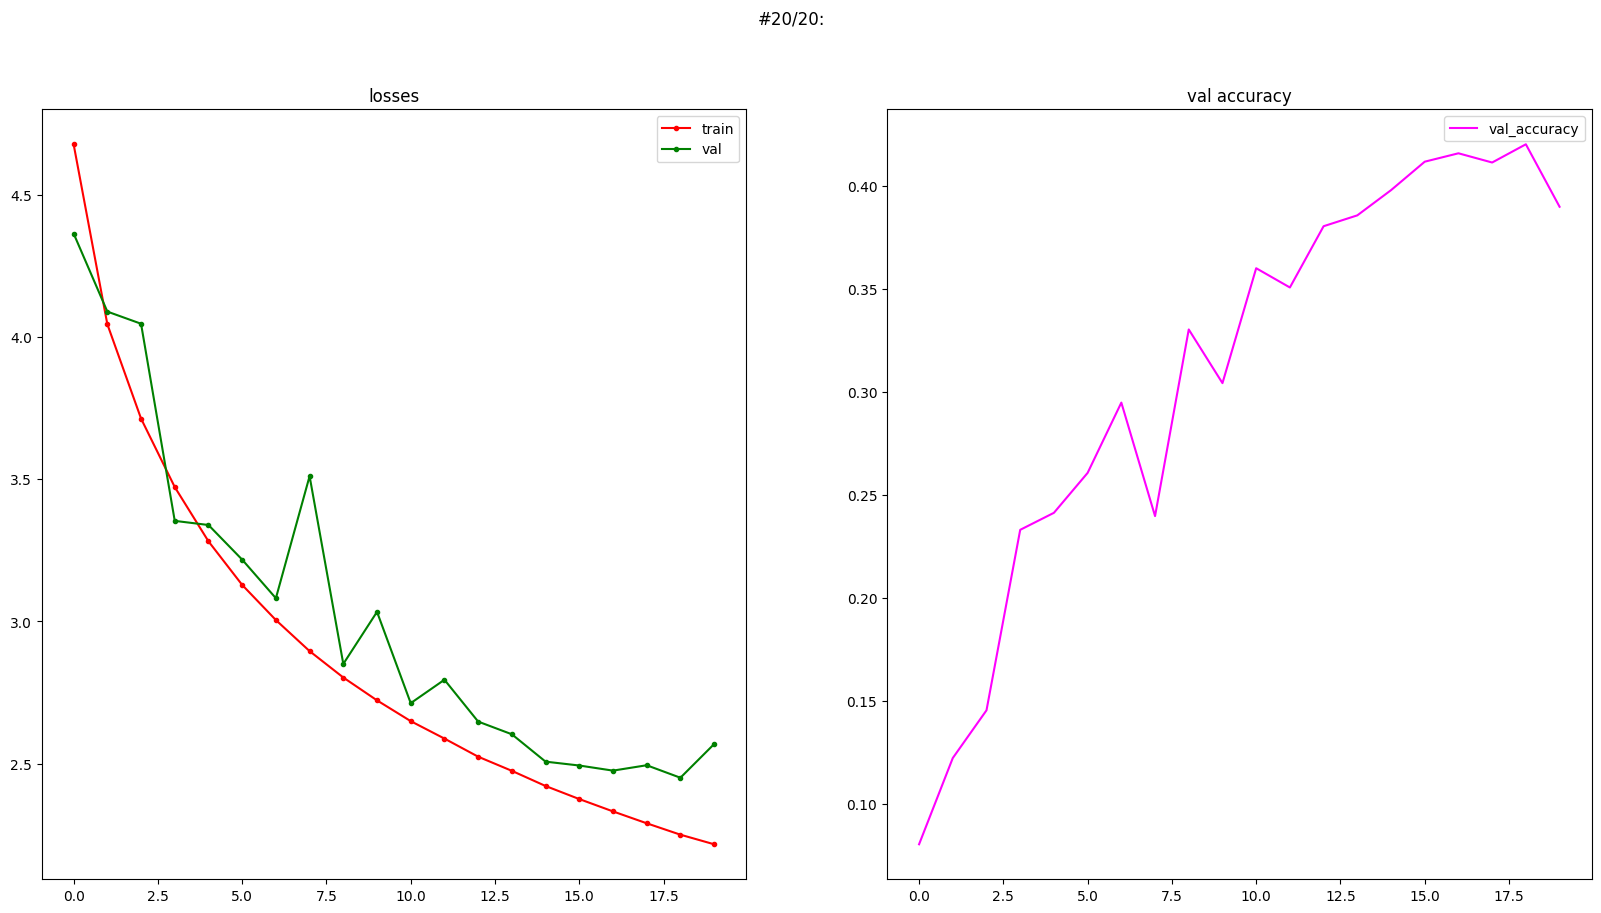

In [ ]:
model, opt, losses = learning_loop(
    model = model,
    optimizer = opt,
    train_loader = train_batch_gen,
    val_loader = val_batch_gen,
    criterion = compute_loss,
    scheduler = scheduler,
    epochs = 20,
    min_lr = 2e-6
)

Вроде сеть достаточно хороша по accuracy, чтобы быть моделью-учителем

In [ ]:
# сохраним модель на всякий случай
from google.colab import files

torch.save(model.state_dict(), 'resnet')
files.download('resnet')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2. Student network
Train small (student) network

Пусть будет MobileNet в качестве модели-студента (как раз там в статье основаня идея - у нас маленькая модель с небольшим количеством параметров и при этом неплохое качество)

In [ ]:
import torch.nn as nn
from torchsummary import summary

def dwise_conv(ch_in, stride=1):
    return (
        nn.Sequential(
            #depthwise
            nn.Conv2d(ch_in, ch_in, kernel_size=3, padding=1, stride=stride, groups=ch_in, bias=False),
            nn.BatchNorm2d(ch_in),
            nn.ReLU6(inplace=True),
        )
    )

def conv1x1(ch_in, ch_out):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

def conv3x3(ch_in, ch_out, stride):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

class InvertedBlock(nn.Module):
    def __init__(self, ch_in, ch_out, expand_ratio, stride):
        super(InvertedBlock, self).__init__()

        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = ch_in * expand_ratio

        self.use_res_connect = self.stride==1 and ch_in==ch_out

        layers = []
        if expand_ratio != 1:
            layers.append(conv1x1(ch_in, hidden_dim))
        layers.extend([
            #dw
            dwise_conv(hidden_dim, stride=stride),
            #pw
            conv1x1(hidden_dim, ch_out)
        ])

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.layers(x)
        else:
            return self.layers(x)

class MobileNetV2(nn.Module):
    def __init__(self, ch_in=3, n_classes=200):
        super(MobileNetV2, self).__init__()

        self.configs=[
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            # [6, 32, 3, 2],
            # [6, 64, 4, 2]
            # [6, 96, 3, 1],
            # [6, 160, 3, 2],
            # [6, 320, 1, 1]
        ]

        self.stem_conv = conv3x3(ch_in, 32, stride=2)

        layers = []
        input_channel = 32
        for t, c, n, s in self.configs:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedBlock(ch_in=input_channel, ch_out=c, expand_ratio=t, stride=stride))
                input_channel = c

        self.layers = nn.Sequential(*layers)

        self.last_conv = conv1x1(input_channel, 64)

        self.classifier = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Linear(64, n_classes)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.stem_conv(x)
        x = self.layers(x)
        x = self.last_conv(x)
        x = self.avg_pool(x).view(-1, 64)
        x = self.classifier(x)
        return x

In [ ]:
student_model = MobileNetV2()
student_model = student_model.to(device)
student_opt = torch.optim.Adam(student_model.parameters(), lr = 0.001)
student_cheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(student_opt, mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True)

In [ ]:
sum_params = model_num_params(student_model)

stem_conv.0.weight  ~  864     params
stem_conv.1.weight  ~  32      params
stem_conv.1.bias    ~  32      params
layers.0.layers.0.0.weight ~  288     params
layers.0.layers.0.1.weight ~  32      params
layers.0.layers.0.1.bias ~  32      params
layers.0.layers.1.0.weight ~  512     params
layers.0.layers.1.1.weight ~  16      params
layers.0.layers.1.1.bias ~  16      params
layers.1.layers.0.0.weight ~  1536    params
layers.1.layers.0.1.weight ~  96      params
layers.1.layers.0.1.bias ~  96      params
layers.1.layers.1.0.weight ~  864     params
layers.1.layers.1.1.weight ~  96      params
layers.1.layers.1.1.bias ~  96      params
layers.1.layers.2.0.weight ~  2304    params
layers.1.layers.2.1.weight ~  24      params
layers.1.layers.2.1.bias ~  24      params
layers.2.layers.0.0.weight ~  3456    params
layers.2.layers.0.1.weight ~  144     params
layers.2.layers.0.1.bias ~  144     params
layers.2.layers.1.0.weight ~  1296    params
layers.2.layers.1.1.weight ~  144     param

Такая модель должна не так хорошо обучиться, так как параметров в разы меньше - 30к против 700к у резнета

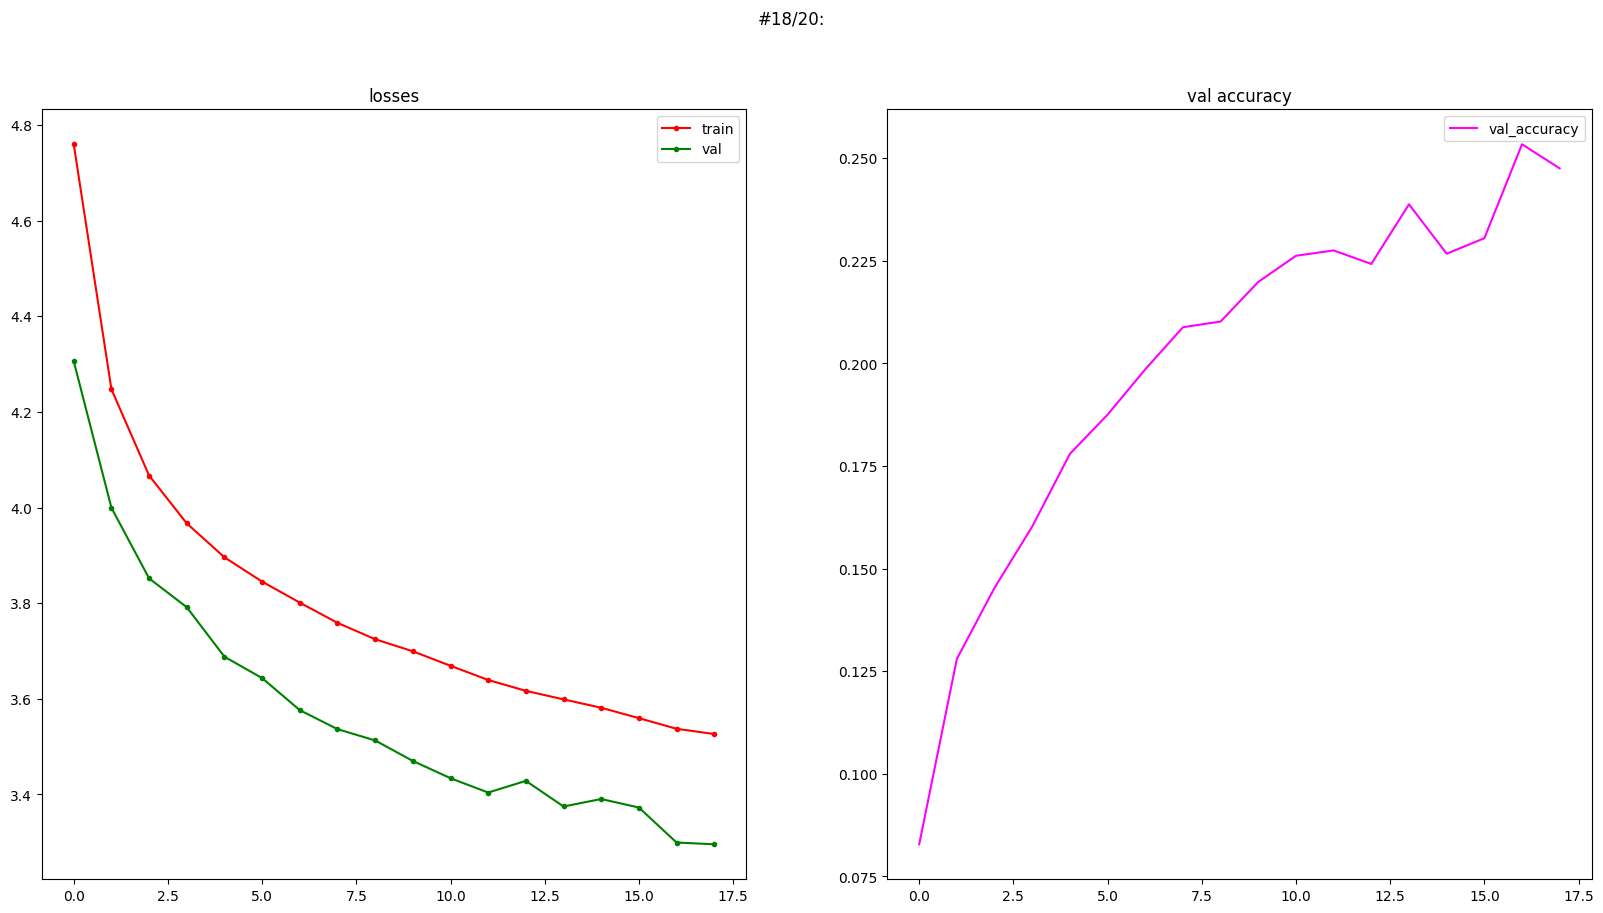

In [ ]:
student_model, student_opt, student_losses = learning_loop(
    model = student_model,
    optimizer = student_opt,
    train_loader = train_batch_gen,
    val_loader = val_batch_gen,
    criterion = compute_loss,
    scheduler = student_cheduler,
    epochs = 20,
    min_lr = 2e-6
)

In [ ]:
len(student_losses['val']) # 20 эпох обучилось, как и надо (а то график лаганул походу)

20

In [ ]:
eval_model(student_model, val_batch_gen)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.24781050955414013

Как раз сгодится в качестве студенческой модели. Запомним это значение, потом будем его сравнивать с distilled model

In [ ]:
from google.colab import files

torch.save(student_model.state_dict(), 'mobile_net')
files.download('mobile_net')

## 3. Knowledge distillation

At this block we will retrain our student network using "knowledge distillation" technique.

The training procedure is the same as for training the student network from scratch except the loss formulation.

Assume that
- $z_i$ are logits predicted by the student network at the current step for an input image
- $v_i$ are logits predicted by the (freezed) teacher network
- $y_i$ are one-hot encoded label of the input image
- $p_i = \frac{\exp{z_i}}{\sum_j \exp{z_j}}$ - logits $z_i$ after sofrmax
- $q_i = \frac{\exp{\frac{z_i}{T}}}{\sum_j \exp{\frac{z_j}{T}}}$, where $T$ is softmax temperature
- $r_i = \frac{\exp{\frac{v_i}{T}}}{\sum_j \exp{\frac{v_j}{T}}}$, where $T$ is the same softmax temperature as for $q_i$

The loss for knowledge distillation: $$-\sum_i y_i \log p_i - \alpha \sum_i r_i \log q_i$$

$T$ and $\alpha$ are hyperparameters.

- There is a good practice of using softmax with high temperature to obtain "soft" distributions, you can start with $T=10$. Check the [post](https://medium.com/mlearning-ai/softmax-temperature-5492e4007f71) with good visualizations on how the temperature affects the softmax output.
- For $\alpha$ there is the following note in the original [paper](https://arxiv.org/pdf/1503.02531.pdf):

> Since the magnitudes of the gradients produced by the soft targets scale as $1/T^2$ it is important to multiply them by $T^2$ when using both hard and soft targets. This ensures that the relative contributions of the hard and soft targets remain roughly unchanged if the temperature used for distillation is changed while experimenting with meta-parameters.

Подгружаем нашу обученную модель-учителя

In [ ]:
teacher_model = create_resnet_like_network()
teacher_model.load_state_dict(torch.load('resnet.file'))

<All keys matched successfully>

In [ ]:
teacher_model = teacher_model.to(device)
teacher_model.eval()

Sequential(
  (init_conv): ConvBNRelu(
    (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (ResNetBlock0): ResNetBlock2(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (ResNetBlock1): ResNetBlock2(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=Tru

Основная задача тут - правильно посчитать лосс, давайте его напишем (все по формулам выше)

In [ ]:
def compute_loss_for_distill(predictions_student, gt, predictions_teacher, T, lambdaa):
    student_loss = compute_loss(predictions_student, gt)

    if T == 0: # делаем равномерное распределение
      soft_preds_student = torch.tensor([[1. / predictions_student.shape[1]] * predictions_student.shape[1]] * predictions_student.shape[0]).to(device)
      soft_preds_teacher = torch.tensor([[1. / predictions_teacher.shape[1]] * predictions_teacher.shape[1]] * predictions_teacher.shape[0]).to(device)
    else:
      soft_preds_student = torch.e ** (predictions_student / T) / (torch.e ** (predictions_student / T)).sum(-1).view(-1,1)
      soft_preds_teacher = torch.e ** (predictions_teacher / T) / (torch.e ** (predictions_teacher / T)).sum(-1).view(-1,1)
    distill_loss = -(soft_preds_teacher * torch.log(soft_preds_student)).sum(-1).mean()

    return student_loss + distill_loss * lambdaa

In [29]:
distill_model = MobileNetV2()
distill_model = distill_model.to(device)
distill_opt = torch.optim.Adam(distill_model.parameters(), lr = 0.001)
distill_cheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(distill_opt, mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True)

Проверяем, что лосс работает

In [ ]:
for images, targets in tqdm(train_batch_gen):
    images = images.to(device)
    targets = targets.to(device)

    out = distill_model(images)
    preds_teacher = teacher_model(images)
    print(compute_loss_for_distill(out, targets, preds_teacher, 5, 5))
    break

  0%|          | 0/1563 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


tensor(31.8686, device='cuda:0', grad_fn=<AddBackward0>)


Тут чуть-чуть нужно поменять циклы обучения, так как еще добавляется Forward pass через учительскую модель

In [ ]:
import torch.nn.functional as F
from tqdm.notebook import tqdm

def train(model, teacher_model, T, lambdaa, optimizer, loader, criterion):
    model.train()
    losses_tr = []
    for images, targets in tqdm(loader):
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        out = model(images)
        preds_teacher = teacher_model(images)
        loss = criterion(out, targets, preds_teacher, T, lambdaa)

        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())

    return model, optimizer, np.mean(losses_tr)

def val(model, teacher_model, T, lambdaa, loader, criterion):
    model.eval()
    losses_val = []
    with torch.no_grad():
        for images, targets in tqdm(loader):
            images = images.to(device)
            targets = targets.to(device)
            out = model(images)
            preds_teacher = teacher_model(images)
            loss = criterion(out, targets, preds_teacher, T, lambdaa)

            losses_val.append(loss.item())

    return np.mean(losses_val)

In [ ]:
from IPython.display import clear_output
from tqdm.notebook import trange
import matplotlib.pyplot as plt


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def learning_loop(model, teacher_model, optimizer, train_loader, val_loader, criterion, T, lambdaa, scheduler=None, min_lr=None,
                  epochs=20, val_every=1, draw_every=1):
    losses = {'train': [], 'val': []}
    val_accuracy = []

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss = train(model, teacher_model, T, lambdaa, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss = val(model, teacher_model, T, lambdaa, val_loader, criterion)
            losses['val'].append(loss)
            if scheduler:
                scheduler.step(loss)
            val_accuracy.append(eval_model(model, val_loader))

        if not (epoch % draw_every):
            clear_output(True)
            fig, ax = plt.subplots(1, 2, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(121)
            plt.title('losses')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()

            plt.subplot(122)
            plt.title('val accuracy')
            plt.plot(val_accuracy, 'magenta', label='val_accuracy')
            plt.legend()

            plt.show()

        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break

    return model, optimizer, losses

For the distillation we
tried temperatures of [1, 2, 5, 10] and used a relative weight of 0.5 on the cross-entropy for the hard
targets - так написано в статье, то есть distillation loss у них был в два раза важнее, так что попробуем с lambda = 2

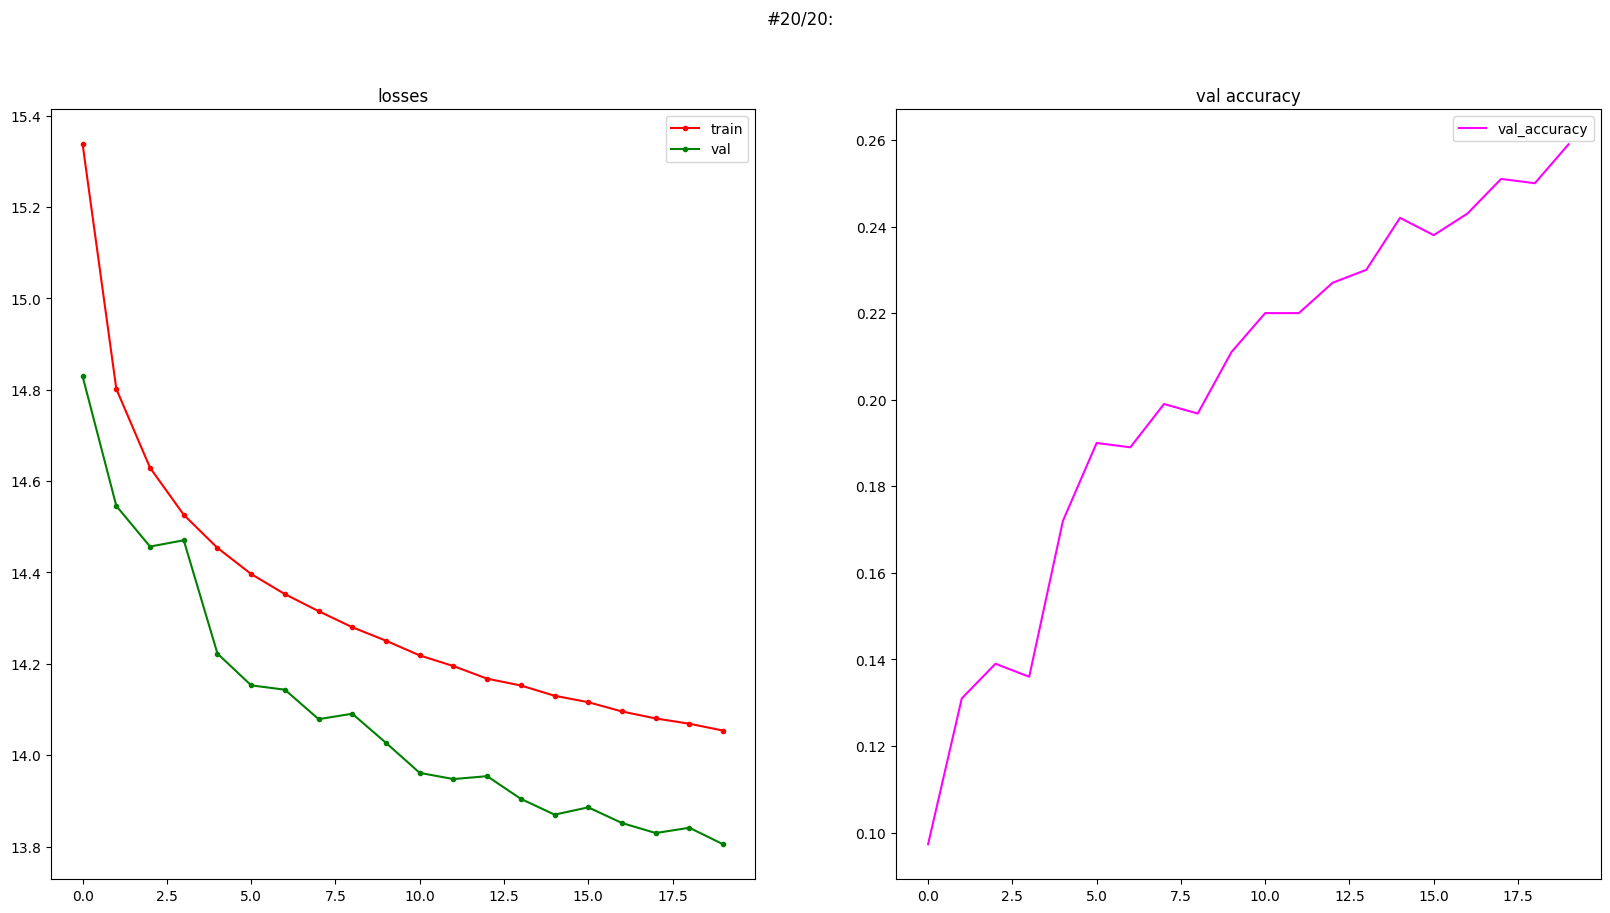

In [45]:
distill_model, distill_opt, distill_losses = learning_loop(
    model = distill_model,
    teacher_model = teacher_model,
    T = 10,
    lambdaa = 2,
    optimizer = distill_opt,
    train_loader = train_batch_gen,
    val_loader = val_batch_gen,
    criterion = compute_loss_for_distill,
    scheduler = distill_cheduler,
    epochs = 20,
    min_lr = 2e-6
)

In [46]:
from google.colab import files

torch.save(distill_model.state_dict(), 'distill_model')
files.download('distill_model')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
eval_model(distill_model, val_batch_gen)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.25925557324840764

Accuracy и правда подросла (была где-то 0.248), значит, наша дистилляция сработала!